<a href="https://colab.research.google.com/github/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/blob/xlnet/XLNet_torch_fine_tuning_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Install necessary packages -> uncomment what is currently needed

!pip install unidecode
!pip install contractions
!pip install wordsegment
!pip install -U symspellpy
!pip install emoji --upgrade
!pip install -U imbalanced-learn
!pip install bert-for-tf2
!pip install transformers
# !pip install nltk

     |████████████████████████████████| 245kB 4.8MB/s 
     |████████████████████████████████| 317kB 6.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81697 sha256=62b18861cd7197df086b25a5004464ad1a64dae59e17febc9c8a1c766264c92d
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 4.8MB 5.0MB/s 
     |████████████████████████████████| 2.6MB 5.0MB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=8dcf2825cdd56f17dafcce90bb6118ca82d03c493561b897709bd8c48c730655
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 163kB 4.6MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imba

In [0]:
# All imports - DO NOT CHANGE THE ORDER OF INSTRUCTIONS
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo

import re
import os
import sys
import json

if not 'bert_repo' in sys.path:
    sys.path.insert(0, 'bert_repo')

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
import spacy
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import emoji
from imblearn.over_sampling import SMOTE
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from modeling import BertModel, BertConfig
from tokenization import FullTokenizer, convert_to_unicode
from extract_features import InputExample, convert_examples_to_features
from tqdm import tqdm
#import tensorflow_addons as tfa
# import nltk
from google.colab import auth, drive
# nltk.download('punkt')

wordsegment.load()

# Load SymSpell -> package for correcting misspellings
sym_spell = SymSpell(2, 7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# get TF logger 
log = logging.getLogger('tensorflow')
log.handlers = []

Cloning into 'bert_repo'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 297.11 KiB | 13.50 MiB/s, done.
Resolving deltas: 100% (183/183), done.


Using TensorFlow backend.


In [0]:
#Import data
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
testing_examples_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/testset-levela.tsv'
testing_labels_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/labels-levela.csv'

training_dataset = pd.read_csv(training_examples_url, delimiter='\t')
testing_dataset_examples_A = pd.read_csv(testing_examples_A_url, delimiter='\t')
testing_dataset_labels_A = pd.read_csv(testing_labels_A_url, delimiter=',')

print(training_dataset.head())
training_dataset.size

      id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]


66200

## **Additional datasets**

In [0]:
#Import 2020 data

training_dataset2020 = pd.read_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/task_a_distant.tsv', delimiter='\t', nrows=500000)

In [0]:
def convert_averages(row):
    return 'OFF' if row['average'] >= 0.4 else 'NOT'


training_dataset2020 = training_dataset2020.drop(labels=['id', 'std'], axis=1)
training_dataset2020['average'] = training_dataset2020.apply(lambda row: convert_averages(row), axis=1)
training_dataset2020 = training_dataset2020.rename(columns={ 'average': 'subtask_a', 'text': 'tweet' })

training_offensive = training_dataset2020[training_dataset2020['subtask_a'] == 'OFF'].head(40000)
training_neutral = training_dataset2020[training_dataset2020['subtask_a'] == 'NOT'].head(40000)

training_dataset = training_dataset.append(training_offensive)
training_dataset = training_dataset.append(training_neutral)
training_dataset = training_dataset.sample(frac=1, random_state=13)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
# # Additional datasets
# set_urls = [
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set1.csv',
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set2.csv',
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set3.csv',
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set4.csv',
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set5.csv'
# ]

# sets = [pd.read_csv(url) for url in set_urls]

In [0]:
# def labels_set1(row):
#   return 'OFF' if 1 in [row['toxic'], row['severe_toxic'], row['obscene'], row['threat'], row['insult'], row['identity_hate']] else 'NOT'

# def labels_set2(row):
#   return 'OFF' if row['class'] != 2 else 'NOT'

# def labels_set_ordinary(row):
#   return 'OFF' if row['subtask_a'] == 1 else 'NOT'

In [0]:
# # Preprocess additional datasets

# sets[0] = sets[0].rename(columns={ 'label': 'subtask_a' })
# sets[0]['subtask_a'] = sets[0].apply(lambda row: labels_set_ordinary(row), axis=1)
# sets[0] = sets[0].drop('id', axis=1)

# sets[1] = sets[1].rename(columns={ 'comment_text': 'tweet', 'label': 'subtask_a' })
# sets[1]['subtask_a'] = sets[1].apply(lambda row: labels_set1(row), axis=1)
# sets[1] = sets[1].drop(labels=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)

# sets[2] = sets[2].rename(columns={ 'label': 'subtask_a' })
# sets[2]['subtask_a'] = sets[2].apply(lambda row: labels_set2(row), axis=1)
# sets[2] = sets[2].drop(labels=['count', 'hate_speech', 'offensive_language', 'neither', 'class', 'Unnamed: 0'], axis=1)

# sets[3] = sets[3].rename(columns={ 'Insult': 'subtask_a', 'Comment': 'tweet' })
# sets[3]['subtask_a'] = sets[3].apply(lambda row: labels_set_ordinary(row), axis=1)
# sets[3] = sets[3].drop('Date', axis=1)

# sets[4] = sets[4].rename(columns={ 'Insult': 'subtask_a', 'Comment': 'tweet' })
# sets[4]['subtask_a'] = sets[4].apply(lambda row: labels_set_ordinary(row), axis=1)
# sets[4] = sets[4].drop(labels=['Date', 'Usage'], axis=1)

# sets_hate_only = [s[s['subtask_a'] == 'OFF'] for s in sets]

# for s in sets: # one can change to sets_hate_only
#   training_dataset = training_dataset.append(s)

# sets_hate_only

# **Training and validation sets**

In [0]:
seed = 13

# prepare training examples
training_examples_A = training_dataset['tweet'][training_dataset['subtask_a'].notnull()]
training_examples_B = training_dataset['tweet'][training_dataset['subtask_b'].notnull()]
training_examples_C = training_dataset['tweet'][training_dataset['subtask_c'].notnull()]

# prepare test examples and labels
test_examples_A = testing_dataset_examples_A['tweet'][testing_dataset_examples_A['tweet'].notnull()]
test_labels_A = (testing_dataset_labels_A['label'][testing_dataset_labels_A['label'].notnull()] == 'OFF').astype(int)

# prepare training labels
training_labels_A = (training_dataset['subtask_a'][training_dataset['subtask_a'].notnull()] == 'OFF').astype(int)
training_labels_B = (training_dataset['subtask_b'][training_dataset['subtask_b'].notnull()] == 'TIN').astype(int)
c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
training_labels_C = training_dataset['subtask_c'][training_dataset['subtask_c'].notnull()].replace(c_mapping)

# split training set into training and validation
training_examples_A, validation_examples_A, training_labels_A, validation_labels_A = train_test_split(
    training_examples_A, training_labels_A, test_size=0.1, stratify=training_labels_A, random_state=seed)
training_examples_B, validation_examples_B, training_labels_B, validation_labels_B = train_test_split(
    training_examples_B, training_labels_B, test_size=0.1, stratify=training_labels_B, random_state=seed)
training_examples_C, validation_examples_C, training_labels_C, validation_labels_C = train_test_split(
    training_examples_C, training_labels_C, test_size=0.1, stratify=training_labels_C, random_state=seed)

training_x = np.array(training_examples_A)
validation_x = np.array(validation_examples_A)
training_y = np.array(training_labels_A)
validation_y = np.array(validation_labels_A)
test_x = np.array(test_examples_A)
test_y = np.array(test_labels_A)

In [0]:
# seed = 13

# # prepare training examples
# training_examples_A = training_dataset['tweet'][training_dataset['subtask_a'].notnull()]
# training_examples_B = training_dataset['tweet'][training_dataset['subtask_b'].notnull()]
# training_examples_C = training_dataset['tweet'][training_dataset['subtask_c'].notnull()]

# # # additional datasets
# # for s in sets:
# #   training_examples_A = pd.concat([training_examples_A, s['tweet']])
# #   break

# # 2020
# data_2020_A = pd.read_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/task_a_distant.tsv', delimiter='\t')[:100000]
# training_examples_A = pd.concat([training_examples_A, data_2020_A['text']])

# # prepare test examples and labels
# test_examples_A = testing_dataset_examples_A['tweet'][testing_dataset_examples_A['tweet'].notnull()]
# test_labels_A = (testing_dataset_labels_A['label'][testing_dataset_labels_A['label'].notnull()] == 'OFF').astype(int)

# # prepare training labels
# training_labels_A = (training_dataset['subtask_a'][training_dataset['subtask_a'].notnull()] == 'OFF').astype(int)
# training_labels_B = (training_dataset['subtask_b'][training_dataset['subtask_b'].notnull()] == 'TIN').astype(int)
# c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
# training_labels_C = training_dataset['subtask_c'][training_dataset['subtask_c'].notnull()].replace(c_mapping)

# # # additional datasets
# # for s in sets:
# #   training_labels_A = pd.concat([training_labels_A, (s['subtask_a'][s['subtask_a'].notnull()] == 'OFF').astype(int)])
# #   break

# # 2020
# training_labels_A = pd.concat([training_labels_A, data_2020_A['average'].transform(lambda x: 1 if x > 0.4 else 0)])

# # split training set into training and validation
# training_examples_A, validation_examples_A, training_labels_A, validation_labels_A = train_test_split(
#     training_examples_A, training_labels_A, test_size=0.1, stratify=training_labels_A, random_state=seed)
# training_examples_B, validation_examples_B, training_labels_B, validation_labels_B = train_test_split(
#     training_examples_B, training_labels_B, test_size=0.1, stratify=training_labels_B, random_state=seed)
# training_examples_C, validation_examples_C, training_labels_C, validation_labels_C = train_test_split(
#     training_examples_C, training_labels_C, test_size=0.1, stratify=training_labels_C, random_state=seed)

# training_x = np.array(training_examples_A)
# validation_x = np.array(validation_examples_A)
# training_y = np.array(training_labels_A)
# validation_y = np.array(validation_labels_A)
# test_x = np.array(test_examples_A)
# test_y = np.array(test_labels_A)

# **Preprocessing**


### Common preprocessing functions

In [0]:
# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)


def preprocess_common(text):
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    return text.lower()

In [0]:
# Remove redundant @user tokens
def remove_redundant_users(example):
    user_count = 0
    new_example = example[:]
    for i, token in reversed(list(enumerate(example))):
        if token == '@user':
            user_count += 1
        if user_count > 3:
            new_example.pop(i)
    else:
        user_count = 0

    return new_example

### Spacy preprocessing

In [0]:
# Try leaving '?' and '!' as far as punctuation is concerned

nlp = spacy.load('en_core_web_sm')

# exclude negation words from spacy stopwords list
deselect_stop_words = ['no', 'not', 'noone', 'none', 'lacks', 'lack', 'nor', 'never', 'neighter', 'hardly', 'nobody', 'nothing', 'lacking', 'nowhere']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

def preprocess_spacy(text):
    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text

        # remove punctuations
        if token.pos_ == 'PUNCT' and flag == True and token.text != '@user': 
            flag = False
       
        # remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        
        # remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False

        # correct misspelings
        # if flag == True:
            # suggestions = sym_spell.lookup(edit, Verbosity.TOP, 2)
            # if len(suggestions) > 0:
                # edit = suggestions[0].term

        # remove stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # convert tokens to base form
        elif token.lemma_ != '-PRON-' and flag == True:
            edit = token.lemma_

        # append tokens edited and not removed to list 
        if edit != '' and flag == True:
            clean_text.append(edit)        
    
    return clean_text

### Preprocessing execution

In [0]:
cleaned_x = [preprocess_spacy(example) for example in training_x[0:30]]
reduced_users_x = [remove_redundant_users(example) for example in cleaned_x]
print(reduced_users_x[0:30])
print(training_x[0:30])

[['@USER', '@USER', 'Dysmo', 'isn', 't', 'like', 'drop'], ['@USER', '@USER', '@USER', 'like', 'way', 'liberal', 'change', 'history'], ['@USER', 'go', 'consult', 'Dictionary', 'Newspeak'], ['@USER', 'guess', 'rotten', 'fruit', 'fall', 'far', 'tree'], ['insecure', ' ', 'no', 'no', 'no', 'no', 'yea', 'dun', 'hab', 'no', 'hell', ' ', 'drop', 'emoji', 'send', 'list'], ['imagine', 'not', 'have', 'time', 'friend', 'people', 'loooolllllll'], ['@95TEEZ', 'FUCKINH', 'scream', 'BC', 'VIDOE'], ['country', 'sick', 'disgusting', 'spawn', 'satan'], ['@user', 'yes', 'not', 'believe', '’s', 'year', 'get', 'hug', 'u', 'not', 'wait'], ['mosquito', 'glassboro', 'say', 'fuck', 'weekend', 'cause', 'wow'], ['penguin', 'invent', 'modjern', 'era', 'wear', 'p*tagonia', 'vest', 'huh'], ['who?"What', 'reply', 'real', 'nigga'], ['y’all', 'need', 'stop', 'fucking', 'play', 'release', 'thing', '\U0001f97a', 'hey', '@user', 'release', 'thing'], ['believe', 'baby', 'hell', 'not', 'believe', '’s', 'damn', 'baby', '😂'],

# **XLNet**

In [0]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 4.5MB/s 


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
def preprocess(text):
  preprocessed_text = preprocess_common(text)
  spacy_x = preprocess_spacy(text)
  cleaned_x = remove_redundant_users(spacy_x)
  return ' '.join(cleaned_x)

In [0]:
# cleaned = [preprocess_spacy(example) for example in training_x[0:30]]
# reduced_users_x = [remove_redundant_users(example) for example in cleaned_x]

# ' '.join(reduced_users_x[0])
# training_x[0]
# preprocess_spacy(training_x[0])

# training_cleaned = [preprocess(example) for example in training_examples_A]
# validation_cleaned = [preprocess(example) for example in validation_examples_A]
# training_cleaned = []
# for i, t in enumerate(training_examples_A):
#   training_cleaned.append(preprocess(t))
#   if i%1000 == 0:
#     print(i, len(training_examples_A))

validation_cleaned = []
for i, t in enumerate(validation_examples_A):
  validation_cleaned.append(preprocess(t))
  if i%1000 == 0:
    print(i, len(validation_examples_A))

# training_sentences = training_cleaned # pd.DataFrame(training_cleaned)['tweet'].values
validation_sentences = validation_cleaned # pd.DataFrame(validation_examples_A)['tweet'].values
# training_sentences[:6]

0 9324
1000 9324
2000 9324
3000 9324
4000 9324
5000 9324
6000 9324
7000 9324
8000 9324
9000 9324


In [0]:
# training_sentences = [sentence + " [SEP] [CLS]" for sentence in training_sentences]
validation_sentences = [sentence + " [SEP] [CLS]" for sentence in validation_sentences]
# training_sentences[:6]

In [0]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)

# training_tokenized_texts = [tokenizer.tokenize(sent) for sent in training_sentences]
validation_tokenized_texts = [tokenizer.tokenize(sent) for sent in validation_sentences]
print ("Tokenize the first sentence:")
# print (training_tokenized_texts[0])

Tokenize the first sentence:


In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 256

In [0]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
# training_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in training_tokenized_texts]
validation_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in validation_tokenized_texts]

In [0]:
# Pad our input tokens
# training_input_ids = pad_sequences(training_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
validation_input_ids = pad_sequences(validation_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
# training_attention_masks = []
validation_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
# for seq in training_input_ids:
#   seq_mask = [float(i>0) for i in seq]
#   training_attention_masks.append(seq_mask)
for seq in validation_input_ids:
  seq_mask = [float(i>0) for i in seq]
  validation_attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, training_y, 
#                                                             random_state=2018, test_size=0.1)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
#                                              random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

# training_number = 2048

train_inputs = torch.tensor(training_input_ids)
validation_inputs = torch.tensor(validation_input_ids)
train_labels = torch.tensor(training_y)
validation_labels = torch.tensor(validation_y)
train_masks = torch.tensor(training_attention_masks)
validation_masks = torch.tensor(validation_attention_masks)

# train_inputs = torch.tensor(training_input_ids[:training_number])
# validation_inputs = torch.tensor(validation_input_ids[:training_number])
# train_labels = torch.tensor(training_y[:training_number])
# validation_labels = torch.tensor(validation_y[:training_number])
# train_masks = torch.tensor(training_attention_masks[:training_number])
# validation_masks = torch.tensor(validation_attention_masks[:training_number])

In [0]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
# batch_size = 8
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-large-cased", num_labels=2)
model.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [0]:
model.sequence_summary

SequenceSummary(
  (summary): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
  (first_dropout): Identity()
  (last_dropout): Dropout(p=0.1, inplace=False)
)

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced',
#                                             np.unique(training_y),
#                                             training_y)
# class_weights /= max(class_weights)

# def weighted_loss(preds, labels):
#   pred_flat = np.argmax(preds, axis=1).flatten()
#   labels_flat = labels.flatten()
#   bce = tf.keras.losses.BinaryCrossentropy()
#   loss = bce(labels_flat, pred_flat)
   
#   return tf.keras.backend.mean(loss * class_weights)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader): ########################
    if step%10 == 0:
      print(step, '/', len(train_dataloader))
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

0 / 3185
10 / 3185
20 / 3185
30 / 3185
40 / 3185
50 / 3185
60 / 3185
70 / 3185
80 / 3185
90 / 3185
100 / 3185
110 / 3185
120 / 3185
130 / 3185
140 / 3185
150 / 3185
160 / 3185
170 / 3185
180 / 3185
190 / 3185
200 / 3185
210 / 3185
220 / 3185
230 / 3185
240 / 3185
250 / 3185
260 / 3185
270 / 3185
280 / 3185
290 / 3185
300 / 3185
310 / 3185
320 / 3185
330 / 3185
340 / 3185
350 / 3185
360 / 3185
370 / 3185
380 / 3185
390 / 3185
400 / 3185
410 / 3185
420 / 3185
430 / 3185
440 / 3185
450 / 3185
460 / 3185
470 / 3185
480 / 3185
490 / 3185
500 / 3185
510 / 3185
520 / 3185
530 / 3185
540 / 3185
550 / 3185
560 / 3185
570 / 3185
580 / 3185
590 / 3185
600 / 3185
610 / 3185
620 / 3185
630 / 3185
640 / 3185
650 / 3185
660 / 3185
670 / 3185
680 / 3185
690 / 3185
700 / 3185
710 / 3185
720 / 3185
730 / 3185
740 / 3185
750 / 3185
760 / 3185
770 / 3185
780 / 3185
790 / 3185
800 / 3185
810 / 3185
820 / 3185
830 / 3185
840 / 3185
850 / 3185
860 / 3185
870 / 3185
880 / 3185
890 / 3185
900 / 3185
910 / 3185

Epoch:  50%|█████     | 1/2 [1:29:45<1:29:45, 5385.52s/it]

Validation Accuracy: 0.8980150322841002
0 / 3185
10 / 3185
20 / 3185
30 / 3185
40 / 3185
50 / 3185
60 / 3185
70 / 3185
80 / 3185
90 / 3185
100 / 3185
110 / 3185
120 / 3185
130 / 3185
140 / 3185
150 / 3185
160 / 3185
170 / 3185
180 / 3185
190 / 3185
200 / 3185
210 / 3185
220 / 3185
230 / 3185
240 / 3185
250 / 3185
260 / 3185
270 / 3185
280 / 3185
290 / 3185
300 / 3185
310 / 3185
320 / 3185
330 / 3185
340 / 3185
350 / 3185
360 / 3185
370 / 3185
380 / 3185
390 / 3185
400 / 3185
410 / 3185
420 / 3185
430 / 3185
440 / 3185
450 / 3185
460 / 3185
470 / 3185
480 / 3185
490 / 3185
500 / 3185
510 / 3185
520 / 3185
530 / 3185
540 / 3185
550 / 3185
560 / 3185
570 / 3185
580 / 3185
590 / 3185
600 / 3185
610 / 3185
620 / 3185
630 / 3185
640 / 3185
650 / 3185
660 / 3185
670 / 3185
680 / 3185
690 / 3185
700 / 3185
710 / 3185
720 / 3185
730 / 3185
740 / 3185
750 / 3185
760 / 3185
770 / 3185
780 / 3185
790 / 3185
800 / 3185
810 / 3185
820 / 3185
830 / 3185
840 / 3185
850 / 3185
860 / 3185
870 / 3185
880

Epoch: 100%|██████████| 2/2 [2:59:33<00:00, 5386.15s/it]  

Validation Accuracy: 0.8992256860371266


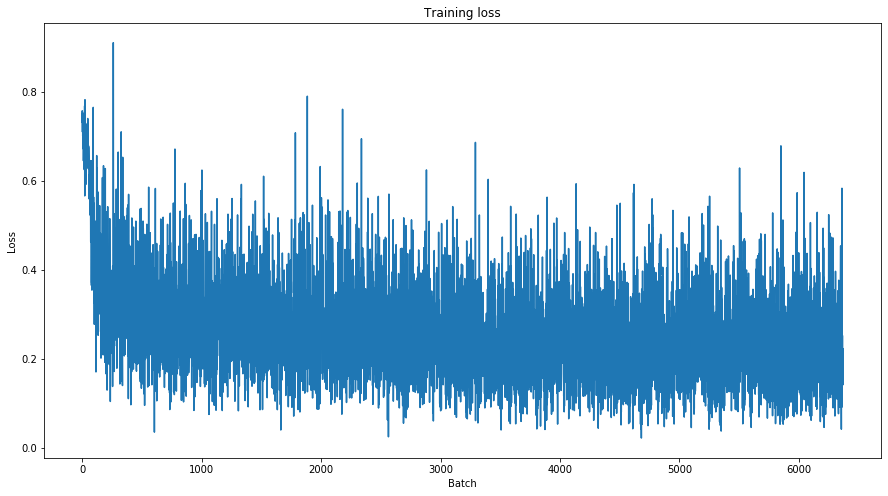

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Save model

In [0]:
torch.save(model.state_dict(), 'gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_2020.pt')

## Load model

In [0]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.load_state_dict(torch.load('gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_2020.pt'))
model.cuda()

100%|██████████| 467042463/467042463 [00:13<00:00, 35418987.27B/s]


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

# Training params evaluation

In [0]:
im_out_train = []
def hook_train(module, input, output):
    im_out_train.append(output)

In [0]:
handle = model.sequence_summary.register_forward_hook(hook_train)

In [0]:
# Create sentence and label lists
sentences = training_sentences

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
# sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = training_y

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on train set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Validation params evaluation

In [0]:
handle.remove()

In [0]:
im_out_val = []
def hook_val(module, input, output):
    im_out_val.append(output)

In [0]:
handle = model.sequence_summary.register_forward_hook(hook_val)

In [0]:
# Create sentence and label lists
sentences = validation_x

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
# sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = validation_y

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
# Prediction on test set

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

matthews_corrcoef(flat_true_labels, flat_predictions)

0.795443081943588

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
f1_val = f1_m(tf.cast(flat_true_labels, tf.float32), tf.cast(flat_predictions, tf.float32))
with tf.Session() as sess:
  print(f1_val.eval()) 

0.89576805


# Test params evaluation

In [0]:
test_cleaned = []
for i, t in enumerate(test_examples_A):
  test_cleaned.append(preprocess(t))
  if i%1000 == 0:
    print(i, len(test_examples_A))

test_sentences = test_cleaned
test_sentences[:6]

0 860


['whoisq wherestheserver # dumpnike # DECLASFISA Democrats Support Antifa Muslim Brotherhood MS13 ISIS Pedophilia Child Trafficking Taxpayer Funded Abortion ’s Election Fraud Sedition Treason # lockthemallup wwg1wga QAnon \u2066@USER url',
 'ConstitutionDay revere Conservatives hate Progressives Socialist Democrats want change',
 'FOXNews NRA maga potus trump RNC USMC veteran @USER     @USER @USER @USER @USER    fakereporte theswamp dnc liberal @user fakeoutrage @USER   reduce url',
 'watch Boomer get news parole make smile # Wentworth Finale @USER treasure url',
 'nopasaran unity demo oppose far right London # antifa Oct13 url',
 'fuck time']

In [0]:
handle.remove()

In [0]:
im_out_test = []
def hook_test(module, input, output):
    im_out_test.append(output)

In [0]:
handle = model.sequence_summary.register_forward_hook(hook_test)

In [0]:
# Create sentence and label lists
sentences = test_sentences

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = test_y

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
# Prediction on test set

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
f1_val = f1_m(tf.cast(flat_true_labels, tf.float32), tf.cast(flat_predictions, tf.float32))
with tf.Session() as sess:
  print(f1_val.eval()) 

0.89576805


## Metrics

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [0]:
matthews_set

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [0]:
matthews_corrcoef(flat_true_labels, flat_predictions)

# Save values

In [0]:
im_train_list = [value.tolist() for rows in im_out_train for value in rows]

In [0]:
im_train_df = pd.DataFrame(im_train_list)
im_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.088829,0.088505,-0.150002,0.470814,-0.368443,-0.084407,-0.197757,-0.575998,0.522692,-0.240471,0.279602,-0.458939,-0.167460,-0.125586,0.544888,-0.533698,0.224816,-0.187636,-0.464352,0.514259,0.048079,0.197121,0.051328,-0.608748,0.335532,-0.057944,-0.229029,0.245387,0.001716,0.587729,0.639800,-0.394966,0.027208,-0.330491,0.107069,-0.065696,0.105836,0.328778,0.607361,0.449024,...,-0.549157,0.242879,-0.360538,0.308664,-0.152292,0.167914,0.122605,0.087077,0.321483,-0.408400,0.533653,0.340319,0.268560,0.092531,-0.421217,-0.352264,0.390190,0.347313,0.047561,-0.017273,-0.236701,-0.338679,0.236763,-0.405946,0.361033,-0.121301,0.619172,0.120684,0.025277,0.040441,-0.005067,0.300719,-0.072390,0.052794,0.400447,-0.201470,-0.036206,0.252792,0.448653,-0.073166
1,-0.290495,-0.807133,0.999253,0.682324,0.992846,-0.792078,-0.370180,0.998575,-0.998597,-0.982364,-0.024523,0.999981,0.951835,0.740192,-0.987150,0.992924,0.334038,0.851453,0.066354,-0.999481,-0.327710,0.995731,-0.971035,0.159541,0.963023,0.984449,-0.825389,-0.908648,0.662652,-0.998408,-0.789831,0.999182,0.959203,0.977901,-0.516699,0.222954,-0.563686,0.971592,-1.000000,-0.988902,...,0.512005,-0.382838,0.998447,-0.394686,0.999933,0.986259,-0.996929,-0.989513,-0.963886,0.994248,-0.999989,0.828765,-0.955574,-0.943424,0.934369,0.976188,0.862190,0.384499,0.147398,0.935163,0.978775,0.557505,0.857106,0.913335,-0.479598,0.351513,-0.999930,0.954453,-0.776501,-0.993441,0.986008,-0.895910,-0.853564,0.417157,-0.996378,0.996664,0.994799,-0.638217,0.967087,-0.127762
2,0.211302,0.166380,-0.259734,0.610295,0.113333,-0.205769,-0.406042,-0.747642,0.575783,-0.309326,0.416895,-0.612826,-0.418226,0.189040,0.705153,-0.760065,0.375470,0.165268,-0.699445,0.763886,0.160314,0.136326,-0.241310,-0.567370,0.534142,-0.041010,-0.562548,0.170133,0.126286,0.531994,0.803330,-0.474910,0.173886,-0.301180,0.324411,-0.002787,0.367045,0.656757,0.581558,0.528959,...,-0.735753,0.687192,-0.486818,0.582003,0.239803,-0.042591,0.352616,0.259451,0.396311,-0.413555,0.760409,0.332179,0.135241,0.681445,-0.626175,-0.587161,0.640835,0.229203,-0.139842,-0.154502,-0.412489,-0.203331,0.424503,-0.544879,0.248321,0.130681,0.640782,0.334500,0.325586,0.103764,0.116682,0.587238,-0.446429,-0.078499,0.347037,-0.258961,-0.325781,0.295261,0.563207,-0.137365
3,0.390482,-0.264205,0.828782,0.782509,0.940238,-0.597394,-0.511256,0.321948,-0.679473,-0.730984,0.407802,0.878829,0.060100,0.608814,0.140738,-0.124314,0.374304,0.763836,-0.769482,-0.184877,0.141622,0.853907,-0.891292,-0.211319,0.887362,0.703651,-0.875445,-0.263629,0.527613,-0.720167,0.494191,0.682051,0.904558,0.566260,0.203886,0.297208,0.416385,0.950675,-0.986932,-0.428935,...,-0.806533,0.806375,0.711509,0.725237,0.991594,0.631183,-0.645978,-0.605981,-0.394369,0.644190,-0.791756,0.499941,-0.625031,0.712918,-0.009501,0.111950,0.860432,-0.105032,-0.511001,0.307093,0.116928,0.194674,0.703632,-0.086933,-0.296165,0.243380,-0.880006,0.849938,0.492304,-0.617226,0.876213,0.506300,-0.852010,-0.120706,-0.825774,0.610381,0.340744,-0.183185,0.862361,-0.172770
4,-0.247859,0.156180,-0.761515,0.519129,-0.910653,0.011996,0.228463,-0.636863,0.879534,0.276133,-0.386900,-0.717761,-0.238550,-0.172188,0.530491,-0.711012,-0.419775,-0.670197,-0.050516,-0.082599,-0.409667,0.402956,0.664061,-0.620658,-0.213514,-0.010501,0.714532,0.441962,0.300694,0.912538,0.294259,-0.734217,-0.373594,-0.855512,0.009851,-0.226691,0.121362,-0.654496,0.980574,0.420819,...,-0.141637,-0.360639,-0.767018,0.155185,-0.972079,-0.228434,-0.230538,-0.299991,0.066847,-0.833317,0.905863,0.072480,0.626879,-0.702910,0.225156,-0.009521,0.157423,0.343433,0.396208,0.112406,-0.351319,-0.666957,-0.464392,-0.585885,0.627450,-0.645041,0.924111,-0.388451,-0.419434,0.300560,-0.057189,-

In [0]:
im_train_df.to_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/params/train_params.csv', index=False)

In [0]:
im_val_list = [value.tolist() for rows in im_out_val for value in rows]

In [0]:
im_val_df = pd.DataFrame(im_val_list)
im_val_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.062641,0.129668,-0.388161,0.452962,-0.562570,-0.052420,-0.227009,-0.688107,0.660464,-0.069676,0.124968,-0.672432,-0.258546,-0.105831,0.683232,-0.686482,0.131488,-0.295960,-0.464643,0.582701,0.009189,0.164878,0.261133,-0.665525,0.243237,-0.153062,-0.065220,0.291176,0.024306,0.715094,0.691204,-0.601995,-0.119387,-0.513865,0.207534,-0.108910,0.170155,0.137531,0.821747,0.526832,...,-0.514494,0.181494,-0.524320,0.307994,-0.459631,0.021770,0.311879,0.177837,0.342033,-0.523964,0.779176,0.306002,0.376874,-0.004620,-0.463297,-0.512302,0.340794,0.437573,0.091670,-0.092309,-0.339105,-0.446648,0.174497,-0.519829,0.392212,-0.196234,0.772769,-0.038350,0.056216,0.194710,-0.181977,0.375435,-0.041072,0.018754,0.513436,-0.394090,-0.243873,0.273724,0.335404,-0.109851
1,0.106575,0.047618,-0.307603,0.480831,-0.294378,-0.088519,-0.259341,-0.648341,0.637322,-0.242937,0.211313,-0.575940,-0.252127,0.029037,0.574745,-0.576280,0.192543,-0.145419,-0.493621,0.557405,0.087083,0.146013,-0.015236,-0.569769,0.427522,-0.082514,-0.140318,0.284033,0.026866,0.597581,0.667300,-0.434824,-0.035206,-0.375756,0.213403,-0.021006,0.240944,0.414456,0.710161,0.392247,...,-0.560661,0.338631,-0.441283,0.451056,-0.065218,0.116955,0.268767,0.040641,0.266318,-0.488378,0.585015,0.376342,0.283817,0.350209,-0.491377,-0.481423,0.482209,0.329469,0.148455,-0.149008,-0.322821,-0.360618,0.276789,-0.402807,0.315483,-0.074678,0.624043,0.133052,0.071685,0.086566,0.038923,0.429055,-0.204286,-0.018201,0.403721,-0.344504,-0.294123,0.302074,0.418411,-0.091956
2,-0.106871,0.240589,-0.701847,0.490309,-0.899594,-0.045881,0.221060,-0.641142,0.815418,0.278951,-0.280055,-0.647724,-0.188373,-0.180357,0.500067,-0.666156,-0.291025,-0.629614,-0.155105,0.097245,-0.355004,0.340970,0.632449,-0.655291,-0.123409,0.011707,0.531942,0.449149,0.243073,0.892299,0.501713,-0.735127,-0.338249,-0.793812,0.053758,-0.159876,0.063896,-0.529306,0.966572,0.525575,...,-0.201931,-0.301162,-0.652964,0.087053,-0.942981,-0.159451,-0.081595,-0.142093,0.199814,-0.773198,0.891835,0.191050,0.593279,-0.624124,0.044397,-0.204498,0.208558,0.391701,0.449353,0.062785,-0.225193,-0.591867,-0.349906,-0.526651,0.538880,-0.514166,0.912412,-0.300820,-0.301109,0.212955,-0.179232,0.043883,0.374623,0.009626,0.652115,-0.128735,-0.003791,-0.042598,-0.165543,-0.217650
3,-0.135950,0.269629,-0.617976,0.400085,-0.819075,-0.030462,0.047303,-0.630952,0.808706,0.178402,-0.234539,-0.624449,-0.286231,-0.164674,0.580430,-0.562934,-0.326581,-0.544372,-0.114811,0.119712,-0.161660,0.287917,0.593385,-0.664855,0.029334,-0.031493,0.527882,0.390058,0.165081,0.853448,0.430695,-0.697404,-0.264025,-0.725842,0.107468,-0.176283,0.024142,-0.436809,0.952311,0.510548,...,-0.308917,-0.286440,-0.690957,0.122078,-0.887693,-0.049215,-0.036104,-0.116162,0.156312,-0.753331,0.824950,0.248702,0.549214,-0.606835,0.020526,-0.111349,0.227320,0.404244,0.373302,-0.085381,-0.318692,-0.562842,-0.259414,-0.504822,0.518609,-0.471913,0.858460,-0.302373,-0.323413,0.200271,-0.174229,0.058144,0.381070,0.143215,0.588112,-0.252380,-0.135845,0.032585,0.004759,-0.105256
4,-0.241068,0.224228,-0.866574,0.648650,-0.951508,-0.063433,0.344618,-0.779191,0.918658,0.491324,-0.497326,-0.821060,-0.278252,-0.142622,0.663219,-0.849294,-0.459091,-0.662951,-0.187047,0.123686,-0.507392,0.405809,0.816148,-0.511135,-0.514167,0.023825,0.597764,0.441453,0.325124,0.931376,0.439042,-0.865668,-0.574023,-0.887404,0.079859,-0.136617,0.132531,-0.778757,0.991472,0.569159,...,-0.257243,-0.330682,-0.882417,0.129946,-0.987404,-0.440516,-0.097217,-0.218145,0.296795,-0.912747,0.966800,-0.126088,0.664480,-0.769673,0.021290,-0.132413,0.092754,0.278919,0.250095,0.037164,-0.353877,-0.689320,-0.626582,-0.760583,0.598453,-0.714302,0.952367,-0.435049,-0.359

In [0]:
im_val_df.to_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/params/val_params.csv', index=False)

In [0]:
im_test_list = [value.tolist() for rows in im_out_test for value in rows]

In [0]:
im_test_df = pd.DataFrame(im_test_list)
im_test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.119583,0.138976,-0.266461,0.479563,-0.372064,-0.094508,-0.265945,-0.673294,0.587286,-0.185186,0.261167,-0.576391,-0.287316,-0.015456,0.648054,-0.676639,0.250636,-0.171893,-0.540958,0.629545,0.032119,0.194977,0.082045,-0.637536,0.358791,-0.079203,-0.252512,0.238975,0.001177,0.615503,0.702206,-0.501927,-0.016172,-0.397049,0.203278,-0.088744,0.229711,0.372786,0.703127,0.484261,...,-0.527264,0.290862,-0.447526,0.351147,-0.213997,0.029340,0.264324,0.161179,0.365134,-0.471409,0.713877,0.305610,0.297981,0.175531,-0.509372,-0.463039,0.401056,0.360400,-0.002483,-0.075729,-0.286869,-0.388846,0.294731,-0.514647,0.336017,-0.121806,0.692028,0.115733,0.133714,0.114883,-0.067028,0.424303,-0.119603,0.064548,0.446374,-0.310813,-0.158333,0.283022,0.466193,-0.092216
1,0.173827,0.091191,-0.293952,0.482024,-0.366347,-0.115883,-0.286038,-0.664378,0.582025,-0.179424,0.238724,-0.587868,-0.280726,-0.009686,0.624946,-0.678595,0.293347,-0.113926,-0.548777,0.642380,0.000164,0.138308,0.071317,-0.636641,0.398749,-0.098908,-0.254478,0.231706,0.031064,0.635855,0.720337,-0.492262,-0.012155,-0.396111,0.215647,-0.073639,0.208063,0.363126,0.712453,0.485344,...,-0.584630,0.343002,-0.465236,0.383966,-0.231631,0.031680,0.282344,0.154441,0.360819,-0.460933,0.711135,0.291582,0.269568,0.215660,-0.520008,-0.509403,0.428154,0.331474,-0.025497,-0.086602,-0.321710,-0.355177,0.281228,-0.485626,0.326338,-0.082555,0.700325,0.057283,0.110115,0.122805,-0.051904,0.435806,-0.146632,0.050315,0.455187,-0.348142,-0.210208,0.320104,0.453082,-0.048726
2,0.223765,0.171737,-0.121036,0.637632,0.282973,-0.279474,-0.371969,-0.743092,0.505025,-0.356952,0.438208,-0.506653,-0.414233,0.177809,0.688589,-0.741078,0.370056,0.279368,-0.735707,0.745852,0.144968,0.186468,-0.330545,-0.510808,0.642715,0.061803,-0.654435,0.171951,0.174196,0.443570,0.787644,-0.353300,0.305128,-0.225829,0.382373,0.086353,0.356802,0.728883,0.416983,0.502036,...,-0.769553,0.716185,-0.424610,0.660672,0.430920,0.056587,0.294046,0.189860,0.338739,-0.407163,0.697125,0.339798,0.166687,0.768763,-0.620485,-0.505049,0.693014,0.191798,-0.200664,-0.152001,-0.397917,-0.149399,0.469198,-0.554133,0.256272,0.185050,0.542040,0.380814,0.430052,0.066658,0.209511,0.590585,-0.520032,-0.055578,0.216532,-0.146930,-0.259765,0.251730,0.656834,-0.173213
3,0.319520,-0.091496,0.410726,0.758682,0.822028,-0.613632,-0.432938,-0.262786,-0.244840,-0.568109,0.526929,0.442106,-0.237499,0.307167,0.544605,-0.543859,0.405545,0.631378,-0.786130,0.499554,0.193032,0.655735,-0.800158,-0.312066,0.857215,0.509818,-0.821468,0.020822,0.367434,-0.318493,0.678315,0.163664,0.659390,0.115006,0.342264,0.152998,0.425530,0.926925,-0.741041,0.139972,...,-0.835415,0.810287,0.195193,0.794344,0.929370,0.334498,-0.268548,-0.344281,-0.025156,0.244354,-0.100292,0.356391,-0.220073,0.850794,-0.377146,-0.151236,0.842654,-0.026470,-0.558033,0.078787,-0.209227,0.036670,0.598149,-0.373351,0.008762,0.398553,-0.341301,0.672018,0.586610,-0.342824,0.703202,0.616752,-0.745608,-0.122510,-0.508739,0.330753,-0.031485,-0.145847,0.838643,-0.208658
4,-0.490453,-0.900595,0.999901,0.679852,0.996824,-0.693950,0.038050,0.999883,-0.999560,-0.991804,0.033771,0.999999,0.988304,0.815715,-0.998158,0.998897,-0.088295,0.756189,0.617554,-0.999952,-0.374118,0.998614,-0.980909,0.003661,0.978619,0.997934,-0.895000,-0.950362,0.567917,-0.999701,-0.899955,0.999929,0.974408,0.996389,-0.715693,0.442761,-0.565202,0.962658,-1.000000,-0.995080,...,0.848286,-0.420534,0.999696,-0.747756,0.999984,0.997150,-0.999324,-0.995216,-0.978219,0.998336,-1.000000,0.845892,-0.984230,-0.992067,0.980395,0.993595,0.845775,0.190591,0.439241,0.978395,0.993068,0.763385,0.829100,0.987396,-0.331825,0.293688,-0.999995,0.942797,-0.939414,-0.998564,0.983689,-0.984372,-

In [0]:
im_test_df.to_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/params/test_params.csv', index=False)

## Test 2020

In [0]:
test_dataset2020 = pd.read_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/test_a_tweets.tsv', delimiter='\t')

In [0]:
test_dataset2020

,id,tweet
0,A0,¿Who the fuck is Yoru?
1,A1,@USER @USER He's an evil law breaker that shou...
2,A2,Now hiring for 49 #Labor job opportunities in ...
3,A3,"#NerkondaPaarvai' - As Of Now, There Is NO Ear..."
4,A4,"@USER Hahahaha I wish...but a week is good, I’..."
...,...,...
3882,A3882,"rt this if you stan EXOT9, follow everyone tha..."
3883,A3883,And then i think that maybe i was designed to ...
3884,A3884,@USER @USER @USER @USER @USER Q for CSIA would...
3885,A3885,@USER Her parents should be in jail for child-...


In [0]:
test_2020_A = test_dataset2020['tweet'][test_dataset2020['tweet'].notnull()]

In [0]:
test_2020_A

0                                  ¿Who the fuck is Yoru?
1       @USER @USER He's an evil law breaker that shou...
2       Now hiring for 49 #Labor job opportunities in ...
3       #NerkondaPaarvai' - As Of Now, There Is NO Ear...
4       @USER Hahahaha I wish...but a week is good, I’...
                              ...                        
3882    rt this if you stan EXOT9, follow everyone tha...
3883    And then i think that maybe i was designed to ...
3884    @USER @USER @USER @USER @USER Q for CSIA would...
3885    @USER Her parents should be in jail for child-...
3886    @USER @USER @USER @USER @USER Trump is a trash...
Name: tweet, Length: 3887, dtype: object

In [0]:
test_2020_cleaned = []
for i, t in enumerate(test_2020_A):
  test_2020_cleaned.append(preprocess(t))
  if i%1000 == 0:
    print(i, len(test_2020_A))

test_2020_sentences = test_2020_cleaned
test_2020_sentences[:6]

0 3887
1000 3887
2000 3887
3000 3887


['¿ fuck Yoru',
 '@USER @USER evil law breaker prison criminal heartless family',
 'hire # Labor job opportunity Minnesota click link bio',
 "NerkondaPaarvai ' Early morning Shows Coimbatore Region    NKP record ADV booking",
 '@USER Hahahaha wish week good be extremely happy long ’ good test drive 🙌',
 'comeback strong setback']

In [0]:
handle.remove()

In [0]:
im_out_test_2020 = []
def hook_test_2020(module, input, output):
    im_out_test_2020.append(output)

In [0]:
handle = model.sequence_summary.register_forward_hook(hook_test_2020)

In [0]:
# Create sentence and label lists
sentences = test_2020_sentences

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
# labels = test_y

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
# prediction_labels = torch.tensor(labels)
  
batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
# Prediction on test set

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
# predictions , true_labels = [], []
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  # true_labels.append(label_ids)

In [0]:
predictions

[array([[-2.785309  ,  2.8553486 ],
        [-1.968389  ,  1.5022422 ],
        [ 2.9765518 , -1.7497731 ],
        [ 2.9763858 , -1.745856  ],
        [ 2.9690788 , -1.78405   ],
        [ 2.9553444 , -1.7638044 ],
        [-1.7279198 ,  1.3030005 ],
        [ 2.9685605 , -1.7578292 ],
        [ 2.14926   , -1.668851  ],
        [ 0.6076746 , -1.2408235 ],
        [ 2.8968651 , -1.7213949 ],
        [ 2.9233139 , -1.7455475 ],
        [ 0.60649383, -1.3209782 ],
        [-2.8309383 ,  2.8938196 ],
        [ 2.937431  , -1.7642434 ],
        [-2.256563  ,  1.979738  ],
        [ 2.9217727 , -1.7339414 ],
        [ 2.8817093 , -1.7533907 ],
        [-2.848118  ,  2.9125335 ],
        [ 2.8899238 , -1.7347527 ],
        [-2.8948324 ,  2.941629  ],
        [ 2.980934  , -1.7777244 ],
        [ 2.7762237 , -1.6520829 ],
        [ 2.941898  , -1.7370325 ],
        [-2.1747015 ,  1.7208112 ],
        [ 2.907214  , -1.760642  ],
        [ 1.8850474 , -1.642528  ],
        [-1.9802351 ,  1.533

In [0]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_predictions

array([1, 1, 0, ..., 0, 1, 1])

In [0]:
np.save('gdrive/My Drive/Pracownia/XLNet_fine_tuning/predictions2020', flat_predictions)

In [0]:
im_test_2020_list = [value.tolist() for rows in im_out_test_2020 for value in rows]

In [0]:
im_test_2020_df = pd.DataFrame(im_test_2020_list)
im_test_2020_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.119583,0.138976,-0.266461,0.479563,-0.372064,-0.094508,-0.265945,-0.673294,0.587286,-0.185186,0.261167,-0.576391,-0.287316,-0.015456,0.648054,-0.676639,0.250636,-0.171893,-0.540958,0.629545,0.032119,0.194977,0.082045,-0.637536,0.358791,-0.079203,-0.252512,0.238975,0.001177,0.615503,0.702206,-0.501927,-0.016172,-0.397049,0.203278,-0.088744,0.229711,0.372786,0.703127,0.484261,...,-0.527264,0.290862,-0.447526,0.351147,-0.213997,0.029340,0.264324,0.161179,0.365134,-0.471409,0.713877,0.305610,0.297981,0.175531,-0.509372,-0.463039,0.401056,0.360400,-0.002483,-0.075729,-0.286869,-0.388846,0.294731,-0.514647,0.336017,-0.121806,0.692028,0.115733,0.133714,0.114883,-0.067028,0.424303,-0.119603,0.064548,0.446374,-0.310813,-0.158333,0.283022,0.466193,-0.092216
1,0.173827,0.091191,-0.293952,0.482024,-0.366347,-0.115883,-0.286038,-0.664378,0.582025,-0.179424,0.238724,-0.587868,-0.280726,-0.009686,0.624946,-0.678595,0.293347,-0.113926,-0.548777,0.642380,0.000164,0.138308,0.071317,-0.636641,0.398749,-0.098908,-0.254478,0.231706,0.031064,0.635855,0.720337,-0.492262,-0.012155,-0.396111,0.215647,-0.073639,0.208063,0.363126,0.712453,0.485344,...,-0.584630,0.343002,-0.465236,0.383966,-0.231631,0.031680,0.282344,0.154441,0.360819,-0.460933,0.711135,0.291582,0.269568,0.215660,-0.520008,-0.509403,0.428154,0.331474,-0.025497,-0.086602,-0.321710,-0.355177,0.281228,-0.485626,0.326338,-0.082555,0.700325,0.057283,0.110115,0.122805,-0.051904,0.435806,-0.146632,0.050315,0.455187,-0.348142,-0.210208,0.320104,0.453082,-0.048726
2,0.223765,0.171737,-0.121036,0.637632,0.282973,-0.279474,-0.371969,-0.743092,0.505025,-0.356952,0.438208,-0.506653,-0.414233,0.177809,0.688589,-0.741078,0.370056,0.279368,-0.735707,0.745852,0.144968,0.186468,-0.330545,-0.510808,0.642715,0.061803,-0.654435,0.171951,0.174196,0.443570,0.787644,-0.353300,0.305128,-0.225829,0.382373,0.086353,0.356802,0.728883,0.416983,0.502036,...,-0.769553,0.716185,-0.424610,0.660672,0.430920,0.056587,0.294046,0.189860,0.338739,-0.407163,0.697125,0.339798,0.166687,0.768763,-0.620485,-0.505049,0.693014,0.191798,-0.200664,-0.152001,-0.397917,-0.149399,0.469198,-0.554133,0.256272,0.185050,0.542040,0.380814,0.430052,0.066658,0.209511,0.590585,-0.520032,-0.055578,0.216532,-0.146930,-0.259765,0.251730,0.656834,-0.173213
3,0.319520,-0.091496,0.410726,0.758682,0.822028,-0.613632,-0.432938,-0.262786,-0.244840,-0.568109,0.526929,0.442106,-0.237499,0.307167,0.544605,-0.543859,0.405545,0.631378,-0.786130,0.499554,0.193032,0.655735,-0.800158,-0.312066,0.857215,0.509818,-0.821468,0.020822,0.367434,-0.318493,0.678315,0.163664,0.659390,0.115006,0.342264,0.152998,0.425530,0.926925,-0.741041,0.139972,...,-0.835415,0.810287,0.195193,0.794344,0.929370,0.334498,-0.268548,-0.344281,-0.025156,0.244354,-0.100292,0.356391,-0.220073,0.850794,-0.377146,-0.151236,0.842654,-0.026470,-0.558033,0.078787,-0.209227,0.036670,0.598149,-0.373351,0.008762,0.398553,-0.341301,0.672018,0.586610,-0.342824,0.703202,0.616752,-0.745608,-0.122510,-0.508739,0.330753,-0.031485,-0.145847,0.838643,-0.208658
4,-0.490453,-0.900595,0.999901,0.679852,0.996824,-0.693950,0.038050,0.999883,-0.999560,-0.991804,0.033771,0.999999,0.988304,0.815715,-0.998158,0.998897,-0.088295,0.756189,0.617554,-0.999952,-0.374118,0.998614,-0.980909,0.003661,0.978619,0.997934,-0.895000,-0.950362,0.567917,-0.999701,-0.899955,0.999929,0.974408,0.996389,-0.715693,0.442761,-0.565202,0.962658,-1.000000,-0.995080,...,0.848286,-0.420534,0.999696,-0.747756,0.999984,0.997150,-0.999324,-0.995216,-0.978219,0.998336,-1.000000,0.845892,-0.984230,-0.992067,0.980395,0.993595,0.845775,0.190591,0.439241,0.978395,0.993068,0.763385,0.829100,0.987396,-0.331825,0.293688,-0.999995,0.942797,-0.939414,-0.998564,0.983689,-0.984372,-

In [0]:
im_test_2020_df.to_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/params/test_2020_params.csv', index=False)